In [2]:
import nilearn
from nilearn.plotting import plot_carpet, plot_glass_brain, plot_anat, plot_stat_map, plot_design_matrix, plot_epi, plot_contrast_matrix
from nilearn import image, masking, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table, make_glm_report
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker, NiftiSpheresMasker
from nilearn import datasets
from nilearn.regions import RegionExtractor
from nilearn import plotting
from nilearn import surface
from nilearn.decoding import Decoder
import seaborn as sns

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Extract fmri and mask files 

In [3]:
subject_id = '02'
fmri_image = list()
mask_image = list()
for run in range(1, 11):
    if run%2 == 0:
        task = 'rotate'
    else:
        task = 'straight'
    fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    fmri_image.append(fmri_file)
    mask_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    mask_image.append(mask_file)


## Extract Events function

In [4]:
events_home_dir = '/home/vm01/Documents/fmri_project_copy/fmri_behavioral_data/'

def get_events_file(subject_id, run):
    events_file = events_home_dir + 'sub-' + subject_id  + '/run-' + str(run).zfill(2) + '/events.csv'
    #events_file = 'events_run_' + str(i) + '.csv'

    events = pd.read_csv(events_file)
    events = events.drop('Unnamed: 0', 1)
    
    #Uncomment below to collapse across go/nogo
    events['trial_type'] = events['trial_type'].replace({'nogo_45_prep':'45_prep', 
                                                 'nogo_99_prep':'99_prep',
                                                 'nogo_153_prep': '153_prep',
                                                 'nogo_207_prep':'207_prep',
                                                 'go_45_prep':'45_prep', 
                                                 'go_99_prep':'99_prep',
                                                 'go_153_prep': '153_prep',
                                                 'go_207_prep':'207_prep'                                                    

                                                })
    
    #Uncomment to do trial_wise events
    events.loc[events.trial_type.str.contains('prep'), 'trial_type'] = events[events.trial_type.str.contains('prep')]['trial_type'].values + '_'+ np.arange(40).astype(str)

    
    #Uncomment to do odd-even events
    
    #sorted_ev = events.sort_values(['trial_type', 'onset'])
    #sorted_ev.loc[sorted_ev.trial_type.str.contains('prep'), 'trial_type'] = sorted_ev[sorted_ev.trial_type.str.contains('prep')].trial_type + '_' + np.tile(['odd', 'even'], 20)
    #events = sorted_ev.sort_index()
    
    return events


In [5]:
events = get_events_file('02', 1)

## Fit glm function
Takes subject id and run number as parameters. 
Events are extracted by the extract events file

In [6]:
def fit_glm(subject_id, run):
    events = get_events_file(subject_id, run)
    tr = 1.25
    n_scans = image.load_img(fmri_image[run-1]).shape[-1]
    frame_times = np.arange(n_scans) * tr
    motion = np.cumsum(np.random.randn(n_scans, 6), 0)
    add_reg_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

    design_matrix = make_first_level_design_matrix(frame_times, events, 
                                               drift_model='polynomial', drift_order=3, 
                                               add_regs=motion, add_reg_names=add_reg_names, 
                                               hrf_model='spm')
    
    fmri_glm_model = FirstLevelModel(t_r=1.25, minimize_memory=False, noise_model='ar1', mask_img=mask_image[run-1])
    fmri_glm_model.fit(fmri_image[run-1], design_matrices=design_matrix)
    print("run done: ", run)
    return fmri_glm_model, design_matrix


## Compute Contrast functions

In [7]:
def compute_no_diff_contrasts(glm, run):
    z_maps = list()
    conditions_label = list()
    sessions_label = list()
    events = get_events_file(subject_id, run)
    conditions = events.trial_type.unique()

    for condition_ in conditions:
        z_maps.append(glm[run-1].compute_contrast(condition_))
        conditions_label.append(condition_)
        sessions_label.append(str(run))
    return z_maps, conditions_label, sessions_label

def get_movement_minus_wait_contrasts(design_matrices, glms):
    z_map_movement_minus_wait = list()
    movement_minus_wait_labels = list()
    for run in range(1, 11):
        contrast_matrix = np.eye(design_matrices[run-1].shape[1])
        basic_contrasts = dict([(column, contrast_matrix[i])
                                for i, column in enumerate(design_matrices[run-1].columns)])        
        movement_contrasts = basic_contrasts['movement_153'] + basic_contrasts['movement_207'] + basic_contrasts['movement_45'] + basic_contrasts['movement_99'] - basic_contrasts['wait']

        z_map_movement_minus_wait.append(glms[run-1].compute_contrast(movement_contrasts))
        movement_minus_wait_labels.append('Movement minus wait, run_' + str(run).zfill(2))
    
    return z_map_movement_minus_wait, movement_minus_wait_labels

def get_prep_minus_wait_contrasts(design_matrices, glms):
    z_map_prep_minus_wait = list()
    prep_minus_wait_labels = list()
    for run in range(1, 11):
        contrast_matrix = np.eye(design_matrices[run-1].shape[1])
        basic_contrasts = dict([(column, contrast_matrix[i])
                                for i, column in enumerate(design_matrices[run-1].columns)])        
        #movement_contrasts = basic_contrasts['go_153_prep'] + basic_contrasts['go_207_prep'] + basic_contrasts['go_45_prep'] + basic_contrasts['go_99_prep'] + basic_contrasts['nogo_153_prep'] + basic_contrasts['nogo_207_prep'] + basic_contrasts['nogo_45_prep'] + basic_contrasts['nogo_99_prep'] - basic_contrasts['wait']
        movement_contrasts = basic_contrasts['45_prep'] + basic_contrasts['99_prep'] + basic_contrasts['153_prep'] + basic_contrasts['207_prep'] - basic_contrasts['wait']
        z_map_prep_minus_wait.append(glms[run-1].compute_contrast(movement_contrasts))
        prep_minus_wait_labels.append('Prep minus wait, run_' + str(run).zfill(2))
    
    return z_map_prep_minus_wait, prep_minus_wait_labels



## Plotting Contrasts functions

Takes z_maps, z_map_no, condition_label as arguments

Default arguments for "display_mode" is 'ortho, "correction" is 'bonferroni', "alpha" is '0.05'  

In [8]:
def plot_contrast_maps(z_maps, z_map_no, condition_label, display_mode = 'ortho', correction = 'bonferroni', alpha = 0.05, output_file = None):    
    _, threshold = threshold_stats_img(
        z_maps[z_map_no], alpha= alpha, height_control=correction)
    print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)

    plot_map = plot_stat_map(z_maps[z_map_no], threshold = threshold, 
                             black_bg=True, display_mode=display_mode, draw_cross=False,
                             title = condition_label[z_map_no] + ' '+ correction + ' corrected, p<0.05',
                             output_file = output_file
                            )
    #masker.fit(z_maps[z_map_no])
    #report = masker.generate_report()
    #plot_map.add_contours(image.index_img(atlas_filename, 11))
    plotting.show()
    return plot_map#, masker
    

In [9]:
def plot_surface_maps(z_maps, z_map_no, condition_label, correction = 'bonferroni', alpha = 0.05):

    _, threshold = threshold_stats_img(
    z_maps[z_map_no], alpha= alpha, height_control=correction)
    print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)

    texture = surface.vol_to_surf(z_maps[z_map_no], fsaverage.pial_left)
    parcellation = destrieux_atlas['map_left']
    regions_dict = {b'G_postcentral': 'Postcentral Gyrus', 
                    b'G_precentral': 'Precentral Gyrus',
                    b'G_pariet_inf-Angular': 'Angular Parietal Inf',
                    b'G_parietal_sup': 'Parietal Sup',
                   }
    regions_indices = [np.where(np.array(destrieux_atlas['labels']) == region)[0][0] for region in regions_dict]
    labels = list(regions_dict.values())
    
    figure = plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi = 'left', 
                                        title = 'Surface left hemisphere', 
                                        colorbar = True, threshold = threshold, 
                                        bgmap = fsaverage.sulc_right)
    plotting.plot_surf_contours(fsaverage.infl_left, parcellation, labels = labels, 
                               levels = regions_indices, figure = figure, legend = True)
    plotting.show()

In [10]:
glms = list()
glm_labels = list()
design_matrices = list()
for run in range(1, 11):
    g, d = fit_glm(subject_id, run)
    glms.append(g)
    glm_labels.append(run)
    design_matrices.append(d)


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  1


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  2


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  3
run done:  4
run done:  5


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  6


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  7


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  8


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  9


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  10


In [157]:
z, l, s = compute_no_diff_contrasts(glms, 1)

In [161]:
z_pw, l_pw = get_prep_minus_wait_contrasts(design_matrices, glms)

In [166]:
plot_contrast_maps(z_pw, 1, l_pw, correction='fdr', output_file='plots_for_bb/prep_minus_wait_rot_fdr.png')

Bonferroni-corrected, p<0.05 threshold: 2.729


In [11]:
np.sort(l)

array(['153_prep_even', '153_prep_odd', '207_prep_even', '207_prep_odd',
       '45_prep_even', '45_prep_odd', '99_prep_even', '99_prep_odd',
       'movement_153', 'movement_207', 'movement_45', 'movement_99',
       'non_movement_153', 'non_movement_207', 'non_movement_45',
       'non_movement_99', 'wait'], dtype='<U16')

In [33]:
subject_id

'01'

In [11]:
## Redo trial level for participant 02

import os
for run in range(1, 11):
    run_no = str(run).zfill(2)
    #Modify paths based on the type of beta maps
    if not os.path.exists(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}'):
        os.mkdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}')
    z, l, s = compute_no_diff_contrasts(glms, run)

    prep_45 = []
    prep_99 = []
    prep_153 = []
    prep_207 = []
    prep = {}

    for i in range(len(l)):
        if l[i].startswith('45'):
            prep_45.append(z[i])
        elif l[i].startswith('99'):
            prep_99.append(z[i])
        elif l[i].startswith('153'):
            prep_153.append(z[i])
        elif l[i].startswith('207'):
            prep_207.append(z[i])

    prep['45'] = image.concat_imgs(prep_45)
    prep['99'] = image.concat_imgs(prep_99)
    prep['153'] = image.concat_imgs(prep_153)
    prep['207'] = image.concat_imgs(prep_207)
    
    for i in prep.keys():
        prep[i].to_filename(f"analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/prep_{i}.nii.gz")
    
    print("Run done: ", run)

Run done:  1
Run done:  2
Run done:  3
Run done:  4
Run done:  5
Run done:  6
Run done:  7
Run done:  8
Run done:  9
Run done:  10


In [158]:
plot_contrast_maps(z, 3, l, correction='fdr', output_file='plots_for_bb/153_prep_str_no_con_fdr.png')

Bonferroni-corrected, p<0.05 threshold: 3.012


In [61]:
np.ravel(np.vstack((np.floor(prep_events['onset']/1.25).astype(int).values, np.floor(prep_events['onset']/1.25).astype(int).values+1)), order='F')

array([  9,  10,  17,  18,  25,  26,  30,  31,  36,  37,  43,  44,  51,
        52,  58,  59,  67,  68,  79,  80,  86,  87,  93,  94, 106, 107,
       112, 113, 120, 121, 128, 129, 135, 136, 147, 148, 155, 156, 161,
       162, 167, 168, 173, 174, 181, 182, 188, 189, 200, 201, 207, 208,
       219, 220, 225, 226, 233, 234, 240, 241, 252, 253, 258, 259, 271,
       272, 278, 279, 284, 285, 292, 293, 300, 301, 308, 309, 314, 315,
       320, 321])

In [131]:
events = get_events_file('02', 1)

,index,153_prep,207_prep,45_prep,99_prep,movement_153,movement_207,movement_45,movement_99,non_movement_153,...,tx,ty,tz,rx,ry,rz,drift_1,drift_2,drift_3,constant
0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,-1.938894,-1.286861,-1.024869,1.314324,0.870943,-0.615606,-0.500000,0.166126,-0.049514,1.0
1,1.25,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,-2.520811,-0.290779,-2.827802,0.065746,2.643268,-1.094873,-0.496753,0.162889,-0.047585,1.0
2,2.50,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,-1.866034,-0.361364,-2.004556,0.934578,1.958391,-0.653409,-0.493506,0.159674,-0.045687,1.0
3,3.75,0.000000,0.000000,0.000003,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,-1.594939,-0.825885,-2.162632,1.724389,-0.396006,-0.247702,-0.490260,0.156480,-0.043821,1.0
4,5.00,0.000000,0.000000,0.007545,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,-1.734125,-1.245145,-1.468545,0.335424,-0.434322,-0.957562,-0.487013,0.153307,-0.041985,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,380.00,-0.035657,0.221837,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.013773,...,-36.277320,6.396038,-14.490609,22.403574,0.633657,3.011150,0.487013,0.153307,0.041985,1.0
305,381.25,-0.030658,0.129123,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.010832,...,-36.100699,4.493569,-14.173896,22.308025,1.096603,3.596440,0.490260,0.156480,0.043821,1.0
306,382.50,-0.024344,0.060221,0.000000,0.000080,0.0,0.0,0.0,0.000000,-0.008192,...,-35.820440,6.852213,-13.056239,21.058548,3.080438,3.924165,0.493506,0.159674,0.045687,1.0
307,383.75,-0.018074,0.014358,0.000000,0.016391,0.0,0.0,0.0,0.000000,-0.005947,...,-35.397291,6.273459,-11.770405,20.361083,2.729719,4.070656,0.496753,0.162889,0.047585,1.0


In [69]:
d_melt = d.reset_index().melt(id_vars=['index'], value_name='event_type')

In [96]:
events = events.sort_values("onset")

In [99]:
events['time_locks'] = events.onset/1.25

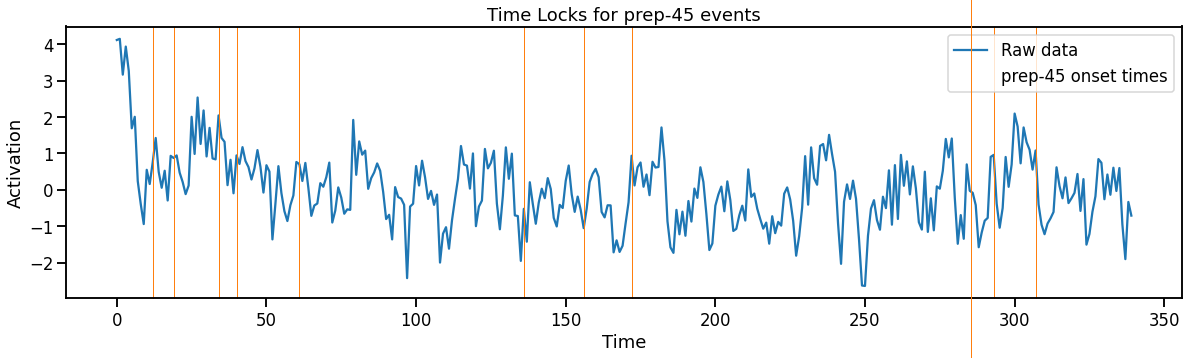

In [124]:
plt.figure(figsize=(20, 5))
plt1, = plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]))
plt2, = plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]),'|', markersize = 2000, markevery = events.query("trial_type == '45_prep'").time_locks.values.astype(int))
plt.legend([plt1, plt2], ['Raw data', 'prep-45 onset times'])
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Time Locks for prep-45 events')
plt.savefig('plots_for_bb/prep_45_time_locks.png', dpi = 600)

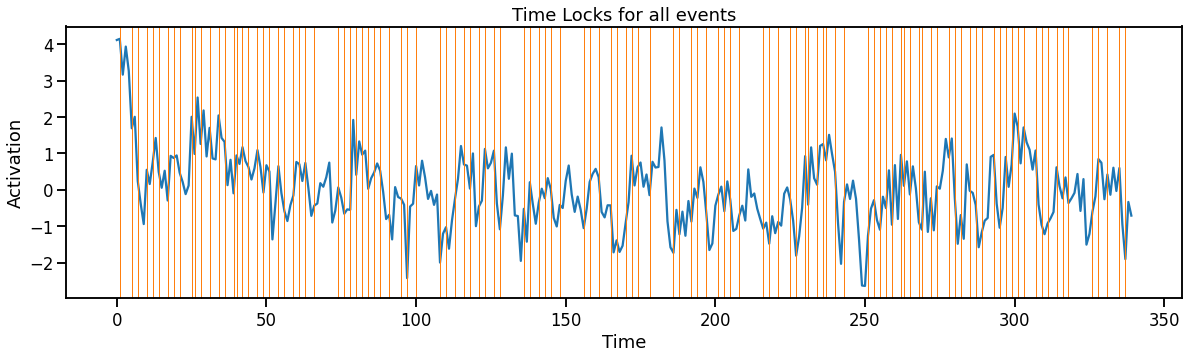

In [125]:
plt.figure(figsize=(20, 5))
plt1, = plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]))
plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]),'|', markersize = 2000, markevery = events.time_locks.values.astype(int))
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Time Locks for all events')
plt.savefig('plots_for_bb/all_time_locks.png', dpi = 600)

Text(0.5, 1.0, 'HRF for prep-45 events')

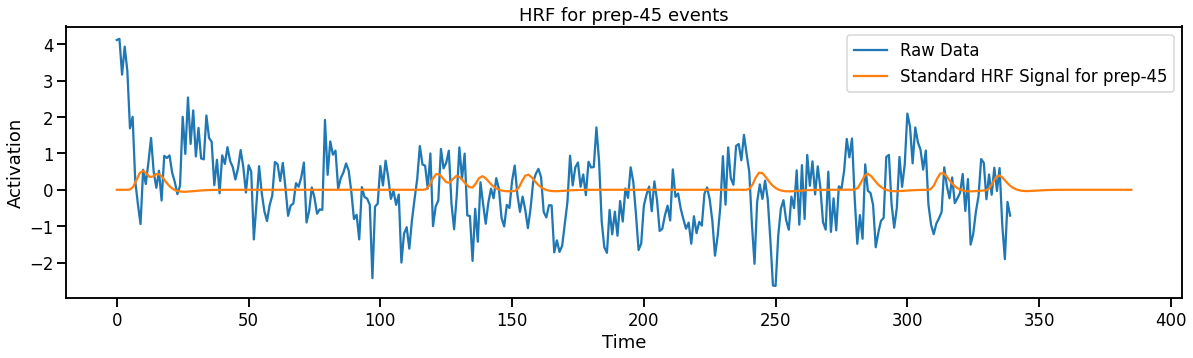

In [138]:
plt.figure(figsize=(20, 5))
plt1, = plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]))
plot_45_prep, = plt.plot(d['45_prep'])
plt.legend([plt1, plot_45_prep], ['Raw Data', 'Standard HRF Signal for prep-45'])
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('HRF for prep-45 events')
#plt.savefig('plots_for_bb/prep_45_hrf.png', dpi = 600)

In [ ]:
plot_153_prep, = plt.plot(d['153_prep'])
plot_99_prep, = plt.plot(d['99_prep'])
plot_207_prep, = plt.plot(d['207_prep'])


In [9]:
atlas = datasets.fetch_atlas_juelich('maxprob-thr25-2mm')

In [10]:
mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == 'GM Primary motor cortex BA4a')[0][0])
resampled_mask = image.resample_to_img(mask_image, fmri_image[0], interpolation='nearest')

In [11]:
masker = NiftiMasker(resampled_mask)

ts = masker.fit_transform(fmri_image[0])
ps = masker.fit_transform(glms[0].predicted[0])

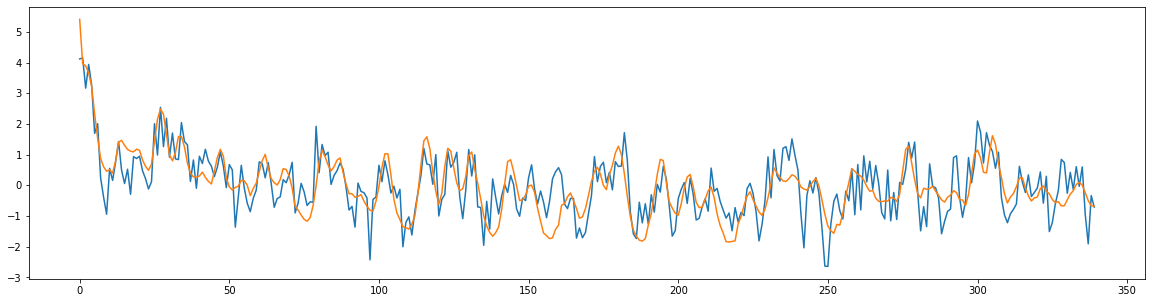

In [31]:
plt.figure(figsize=(20, 5))
plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]))
plt.plot(ps[:, 20])

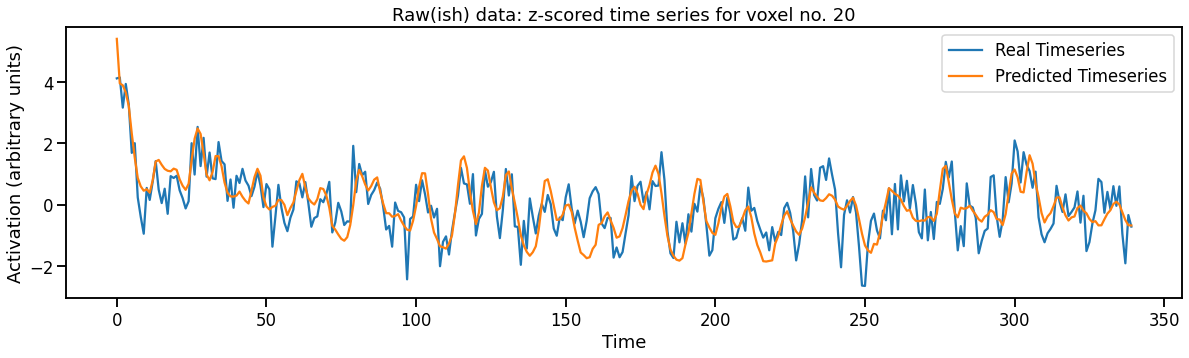

In [62]:
sns.set_context('talk')
plt.figure(figsize=(20, 5))
plot1, = plt.plot((ts[:, 20] - np.mean(ts[:, 20]))/np.std(ts[:, 20]))
plot2, = plt.plot(ps[:, 20])
plt.legend([plot1, plot2], ['Real Timeseries', 'Predicted Timeseries'])
plt.ylabel('Activation (arbitrary units)')
plt.xlabel('Time')
plt.title('Raw(ish) data: z-scored time series for voxel no. 20')
plt.savefig('plots_for_bb/overlaid_predicted_ts.png', dpi = 600)

In [36]:
d_melt = d.melt(var_name='event', value_name='act')

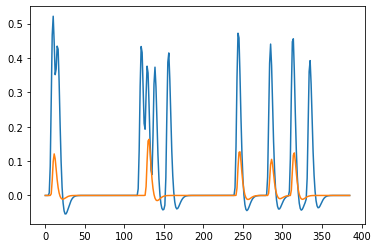

In [54]:
#plt.plot(d['153_prep'])
#plt.plot(d['207_prep'])
plt.plot(d['45_prep'])
#plt.plot(d['99_prep'])
plt.plot(d['movement_45'])
#plt.plot(d['non_movement_45'])


In [167]:
mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == 'GM Primary motor cortex BA4a')[0][0])
resampled_mask = image.resample_to_img(mask_image, z[0], interpolation='nearest')

In [170]:
masker = NiftiMasker(resampled_mask)
masker.fit(fmri_image[0])

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f545d09eca0>)

In [171]:
report = masker.generate_report()
report

MemoryError: Unable to allocate 1.47 GiB for an array with shape (79, 94, 78, 340) and data type float64

In [190]:
nifti_masker = NiftiMasker(standardize=True, mask_strategy='whole-brain-template')
nifti_masker.fit(prep_images)
mask_img = nifti_masker.mask_img_

In [191]:
nifti_masker.fit(prep_images)
fmri_masked = nifti_masker.transform(prep_images)

In [192]:
fmri_masked.shape

(80, 111559)

In [193]:
conditions = prep_events.target_location.values 